Вариационный вывод --- mean-field, sgd, langevin

In [1]:
import numpy as np
import theano
import theano.tensor as T
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc


#rc('text', usetex=False)
#matplotlib.rcParams["mathtext.fontset"] = "cm"

In [3]:
cov = np.array([[2,1.8],[1.8,2]])
print cov

[[2.  1.8]
 [1.8 2. ]]


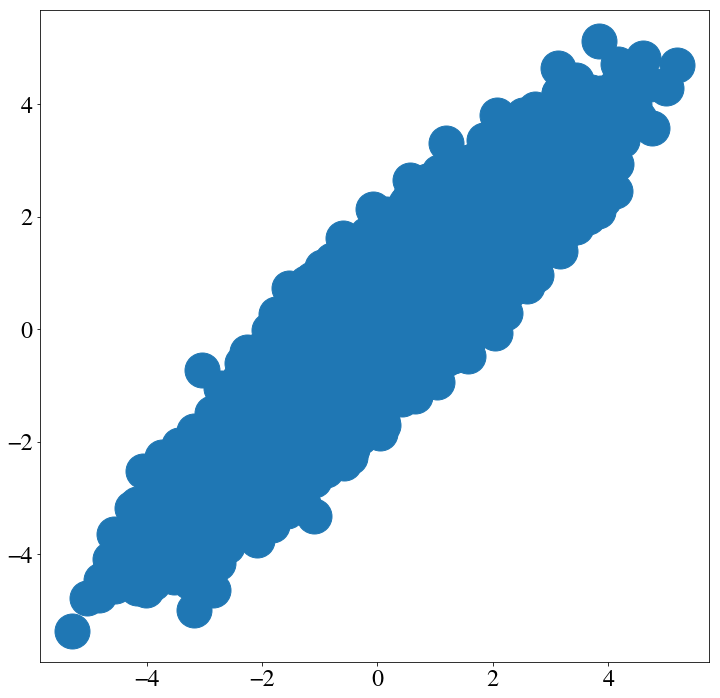

In [5]:
import scipy as sp
N = 10000
mu_actual = np.zeros(2)

#x = sp.stats.multivariate_normal.rvs(mu_actual, matrix, size=N)
data = np.random.multivariate_normal(mu_actual, cov, N)
plt.scatter(data[:,0],data[:,1])
#np.save('var_data',data)
data = np.load('var_data.npy')
#plt.savefig('data_generated.pdf')

posterior, assume mean is normal(0, ONES)

In [6]:
prior_cov = np.eye(2)
post_mean = np.dot(np.linalg.inv(np.linalg.inv(prior_cov)+N*np.linalg.inv(cov)) ,np.dot(N*np.linalg.inv(cov) , np.mean(data,axis=0)))
print post_mean

post_cov = np.linalg.inv(np.linalg.inv(prior_cov)+N*np.linalg.inv(cov))


[-0.01980703 -0.01926181]


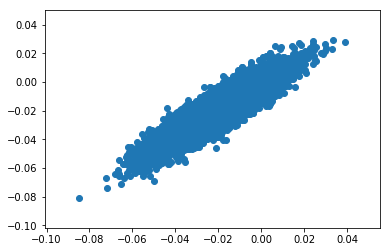

In [6]:
data_posterior = np.random.multivariate_normal(post_mean, post_cov, N)
plt.scatter(data_posterior[:,0],data_posterior[:,1])

SGD

In [7]:
import theano
import theano.tensor as T
X = T.matrix()
params = theano.shared(np.random.randn(2,))
n = 1000
cost =  T.sum(T.sum(T.dot(X-params, np.linalg.inv(cov)) * (X-params), axis=1))*N/n+ (params[0]**2 + params[1]**2)
#T.sum(T.dot((X-params).T, (X-params)))#T.sum(T.dot(T.dot(X-params, np.linalg.inv(cov)),(X-params).T))# + (params[0]**2 + params[1]**2)
grad = T.grad(cost,params)
train = theano.function([X], cost,updates=[(params,params - 0.000001*grad)])

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [8]:
points = []
points2 = []
for i in range(0,50):
    params.set_value(np.random.randn(2,))
    for j in xrange(0,2000):
        np.random.shuffle(data)
        train(data[:n])
        if j==600:
            points.append(params.eval())
        if j%100==0:
            print i,j, params.eval()
    points2.append(params.eval())  

0 0 [1.56047663 0.66889333]
0 100 [0.64682184 0.64660165]
0 200 [0.36958263 0.37166339]
0 300 [0.20859066 0.2063237 ]
0 400 [0.11403986 0.11258672]
0 500 [0.06115196 0.05879434]
0 600 [0.03291964 0.02969813]
0 700 [0.00856059 0.01287489]
0 800 [-0.00123252  0.00045703]
0 900 [-0.00726034 -0.00752305]
0 1000 [-0.01033533 -0.0131696 ]
0 1100 [-0.01757326 -0.01553726]
0 1200 [-0.01658932 -0.01684364]
0 1300 [-0.01810224 -0.01660807]
0 1400 [-0.01464256 -0.02045799]
0 1500 [-0.01631292 -0.02077434]
0 1600 [-0.01842595 -0.01933097]
0 1700 [-0.02530081 -0.01764573]
0 1800 [-0.02615743 -0.02136699]
0 1900 [-0.02108415 -0.02112977]
1 0 [1.02413069 1.33773671]
1 100 [0.68698769 0.68815451]
1 200 [0.39801925 0.39591086]
1 300 [0.2289496  0.22165443]
1 400 [0.12611572 0.12283252]
1 500 [0.06229565 0.06154779]
1 600 [0.02922725 0.02645113]
1 700 [0.00835075 0.00680152]
1 800 [-0.00177461 -0.00043562]
1 900 [-0.01019383 -0.00877562]
1 1000 [-0.01820916 -0.01445617]


KeyboardInterrupt: 

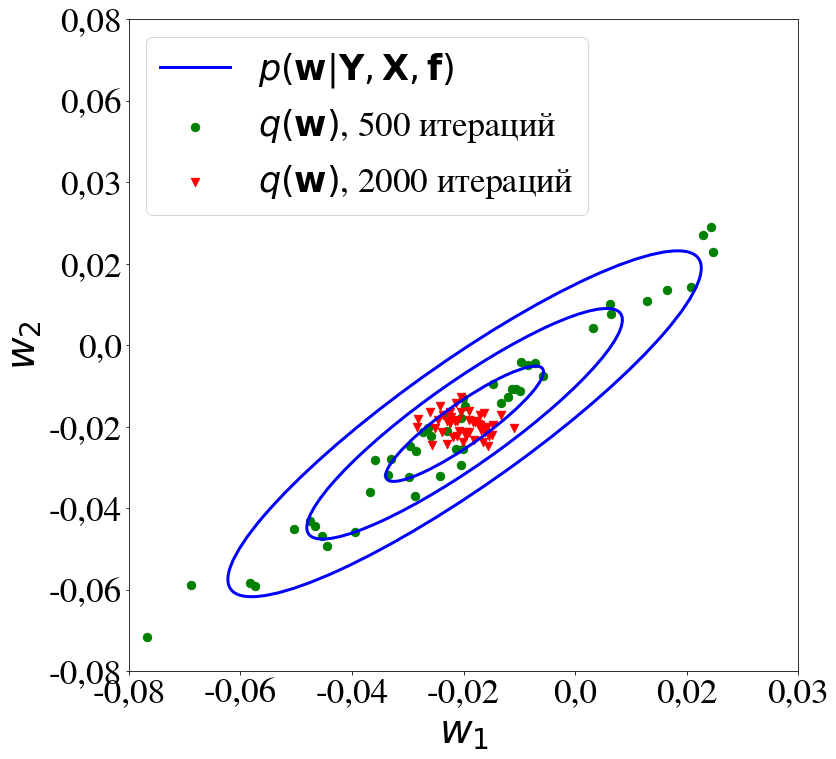

In [27]:

#points = np.array(points)
#points2 = np.array(points2)
#np.save('sgd_posterior_500', points)
#np.save('sgd_posterior_2000', points2)
from matplotlib.patches import Ellipse
from plot_style import init_rc_params
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as tkr
fig, ax = plt.subplots()


init_rc_params()

plt.rcParams['figure.figsize'] = (12,12)
points = np.load('sgd_posterior_500.npy')
points2 = np.load('sgd_posterior_2000.npy')
lambda_, v = np.linalg.eig(post_cov)
lambda_ = np.sqrt(lambda_)
ax = plt.subplot(111)

def func(x, pos):  # formatter function takes tick label and tick position
    s = str(x)
    ind = s.index('.')
    return s[:ind] + ',' + s[ind+1:ind+3]   # change dot to comma



y_format = tkr.FuncFormatter(func)  # make formatter


ax.yaxis.set_major_formatter(y_format)
ax.xaxis.set_major_formatter(y_format)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='b', fc='None', label=u'Апостериорное распределение параметров', linewidth=3)
    
    ax.add_artist(ell)
    
#plt.scatter(data_posterior[:,0],data_posterior[:,1],alpha=0.2)
#font = {'family': 'sans-serif',
#        'weight': 'normal',
#        'size': 20}
#rc('font', **font)
plt.rcParams['mathtext.rm']='arial'
plt.plot([-1110],[-1000], c='b', label='$p(\mathbf{w}|\mathbf{Y}, \mathbf{X},\mathbf{f})$', linewidth=3)
#print plt.rcParams
#font = {'family': 'Droid Sans',
#        'weight': 'bold',
#        'size': 20}
#rc('font', **font)
plt.scatter(points[:,0],points[:,1], c='g', label=u'$q(\mathbf{w})$, 500 итераций', s=70)
plt.scatter(points2[:,0],points2[:,1], c='r', marker='v', label=u'$q(\mathbf{w})$, 2000 итераций', s=70)
plt.xlim((-.08,.04))
plt.ylim((-.08,.08))
plt.tick_params(axis='both', which='major', labelsize=35)
plt.xlabel('$w_1$', fontsize=40)
plt.ylabel('$w_2$', fontsize=40)
plt.legend(loc=u'upper left',fontsize=35)
plt.savefig('../var/sgd.pdf', dpi=100)

Langevin 

In [10]:
start_lr =  0.00002
lr = theano.shared(start_lr)
from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams()
r = srng.normal((2,)) * T.sqrt(2*lr)
train_lang = theano.function([X], cost,updates=[(params,params - lr*grad + r)])

In [23]:
1/0
points3 = []
points4 = []
for i in range(0,50):
    params.set_value(np.random.randn(2,))
    for j in range(0,2000):
        lr.set_value((start_lr*(j+1)**(-0.51)))
        np.random.shuffle(data)
        train_lang(data[:n])
        if j==500:
            points3.append(params.eval())
        if j%100==0:
            print i,j, params.eval()
    points4.append(params.eval())  

ZeroDivisionError: integer division or modulo by zero

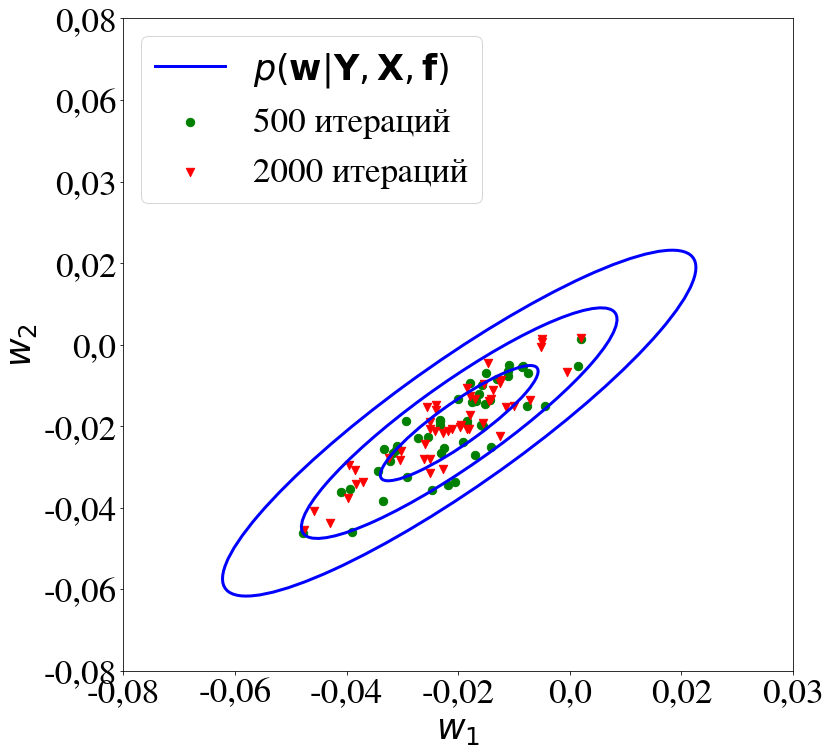

In [28]:
#points3 = np.array(points3)
#points4 = np.array(points4)
from matplotlib.patches import Ellipse
#np.save('lang_posterior_500', points3)
#np.save('lang_posterior_2000', points4)
points3 = np.load('lang_posterior_500.npy')
points4 = np.load('lang_posterior_2000.npy')

lambda_, v = np.linalg.eig(post_cov)
lambda_ = np.sqrt(lambda_)
ax = plt.subplot(111)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='b', fc='None', label=u'Апостериорное распределение параметров', linewidth=3)
    
    ax.add_artist(ell)
    

def func(x, pos):  # formatter function takes tick label and tick position
    s = str(x)
    ind = s.index('.')
    return s[:ind] + ',' + s[ind+1:ind+3]   # change dot to comma



y_format = tkr.FuncFormatter(func)  # make formatter


ax.yaxis.set_major_formatter(y_format)
ax.xaxis.set_major_formatter(y_format)



#plt.scatter(data_posterior[:,0],data_posterior[:,1],alpha=0.2)
plt.scatter(points3[:,0],points3[:,1], c='g', label=u'500 итераций', s=70)
plt.scatter(points4[:,0],points4[:,1], c='r', marker='v', label=u'2000 итераций', s=70)
plt.plot([-100],[-100], label=u'$p(\mathbf{w}|\mathbf{Y}, \mathbf{X},\mathbf{f})$', c='b', linewidth=3)
plt.xlim((-.08,.04))
plt.ylim((-.08,.08))
plt.tick_params(axis='both', which='major', labelsize=35)
plt.xlabel('$w_1$', fontsize=35)
plt.ylabel('$w_2$',fontsize=35)

plt.legend(loc=u'upper left', fontsize=35)
plt.savefig('../var/lang.pdf', dpi=100)

Mean-field, возможно формула слегка неверна, но допустима для демонстрации

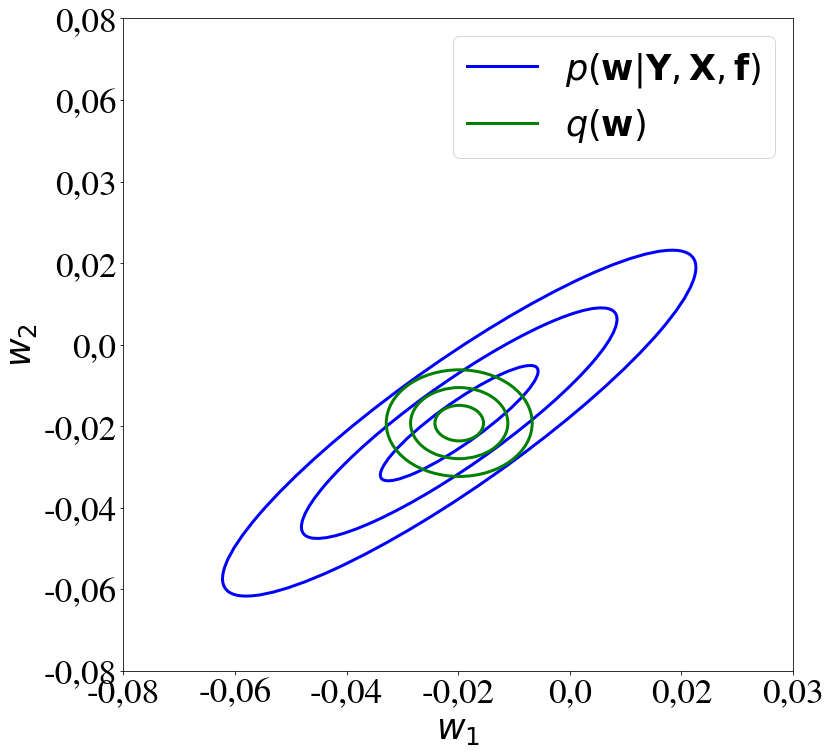

In [30]:
from matplotlib.patches import Ellipse
lambda_, v = np.linalg.eig(post_cov)
lambda_ = np.sqrt(lambda_)
ax = plt.subplot(111)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='b', alpha=1.0, fc='None', label=u'Апостериорное распределение параметров', linewidth=3)
    
    ax.add_artist(ell)
plt.legend([ell],[u'Апостериорное распределение параметров'])
old_ell = ell
side =  0.5/(post_cov[1,1]/np.linalg.det(post_cov))
cov_mean_field = np.array([[side, 0],[0,side]])
lambda_, v = np.linalg.eig(cov_mean_field)
lambda_ = np.sqrt(lambda_)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='g', fc='None', label=u'Mean-field аппроксимация', linewidth=3)
    
    ax.add_artist(ell)
#plt.legend([old_ell, ell],[u'Апостериорное распределение параметров', u'Mean-field аппроксимация'])
plt.plot([-100],[-100], label=u'$p(\mathbf{w}|\mathbf{Y}, \mathbf{X},\mathbf{f})$',alpha=1.0, c='b', linewidth=3)
plt.plot([-100],[-100], label=u'$q(\mathbf{w})$', c='g', linewidth=3)
plt.legend(loc='best', fontsize=35)  
plt.tick_params(axis='both', which='major', labelsize=35)
plt.xlabel('$w_1$', fontsize=35)
plt.ylabel('$w_2$',fontsize=35)

def func(x, pos):  # formatter function takes tick label and tick position
    s = str(x)
    ind = s.index('.')
    return s[:ind] + ',' + s[ind+1:ind+3]   # change dot to comma



y_format = tkr.FuncFormatter(func)  # make formatter


ax.yaxis.set_major_formatter(y_format)
ax.xaxis.set_major_formatter(y_format)

plt.xlim((-.08,.04))
plt.ylim((-.08,.08))

plt.savefig('../var/mf.pdf', dpi=100)


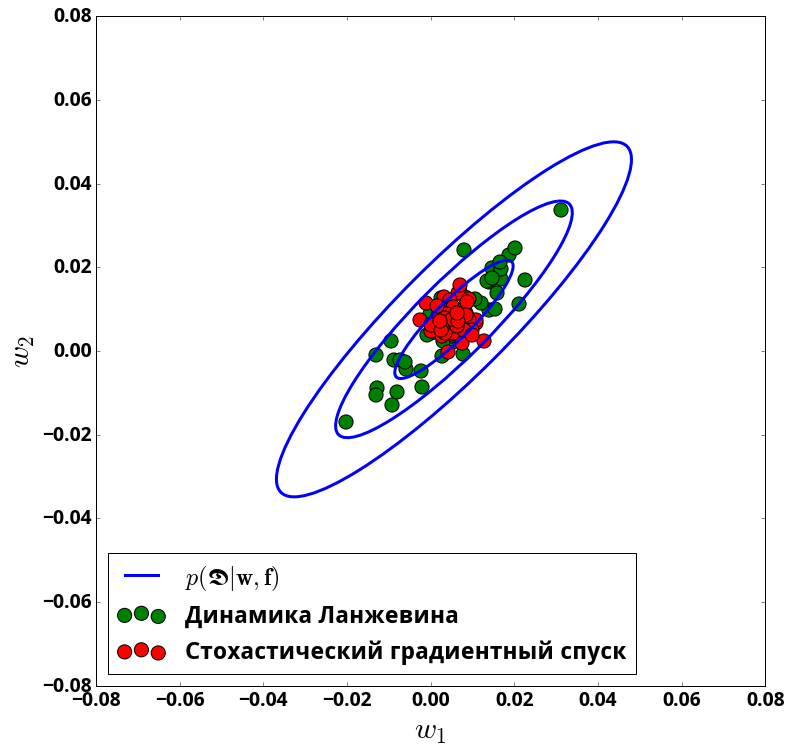

In [82]:
#points3 = np.array(points3)
#points4 = np.array(points4)
from matplotlib.patches import Ellipse
#np.save('lang_posterior_500', points3)
#np.save('lang_posterior_2000', points4)
points3 = np.load('sgd_posterior_2000.npy')
points4 = np.load('lang_posterior_2000.npy')

lambda_, v = np.linalg.eig(post_cov)
lambda_ = np.sqrt(lambda_)
ax = plt.subplot(111)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='b', fc='None', label=u'Апостериорное распределение параметров', linewidth=3)
    
    ax.add_artist(ell)




#plt.scatter(data_posterior[:,0],data_posterior[:,1],alpha=0.2)
plt.scatter(points4[:,0],points4[:,1], c='g', label=u'Динамика Ланжевина', s=200)
plt.scatter(points3[:,0],points3[:,1], c='r', label=u'Стохастический градиентный спуск', s=200)
plt.plot([-100],[-100], label=u'$p(\mathbf{\mathfrak{D}}|\mathbf{w,f})$', c='b', linewidth=3)
plt.xlim((-.08,.08))
plt.ylim((-.08,.08))
plt.xlabel('$w_1$', fontsize=30)
plt.ylabel('$w_2$',fontsize=30)

plt.legend(loc=u'lower left')
plt.savefig('langevin_estimate.png', dpi=100)

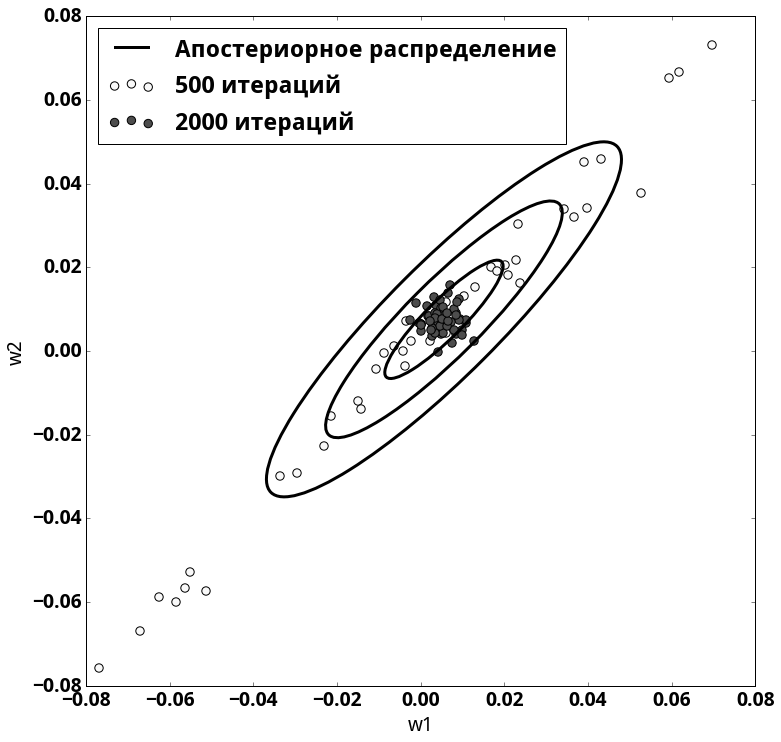

In [18]:
#points = np.array(points)
#points2 = np.array(points2)
#np.save('sgd_posterior_500', points)
#np.save('sgd_posterior_2000', points2)
from matplotlib.patches import Ellipse
points = np.load('sgd_posterior_500.npy')
points2 = np.load('sgd_posterior_2000.npy')
lambda_, v = np.linalg.eig(post_cov)
lambda_ = np.sqrt(lambda_)
ax = plt.subplot(111)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='k', fc='None', label=u'Апостериорное распределение параметров', linewidth=3)
    
    ax.add_artist(ell)
    
#plt.scatter(data_posterior[:,0],data_posterior[:,1],alpha=0.2)
plt.plot([-1000], [-10000], c='k', label=u'Апостериорное распределение', linewidth=3)
plt.scatter(points[:,0],points[:,1], c='0.975', label=u'500 итераций', s=70)
plt.scatter(points2[:,0],points2[:,1], c='0.3', label=u'2000 итераций', s=70)
plt.xlim((-.08,.08))
plt.ylim((-.08,.08))
plt.xlabel('w1')
plt.ylabel('w2')
plt.legend(loc=u'upper left')
plt.savefig('sgd_estimate_doc.pdf')

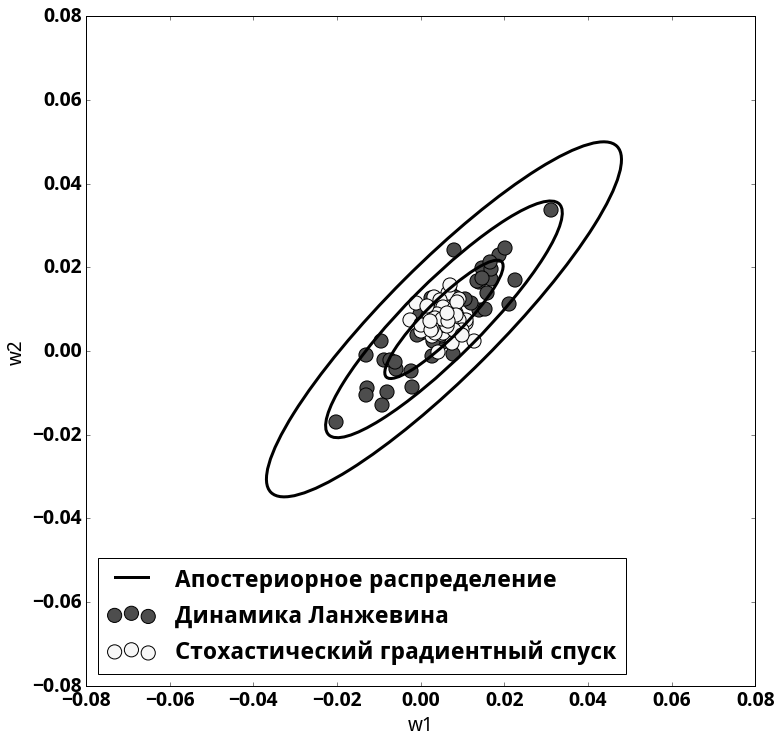

In [26]:
#points3 = np.array(points3)
#points4 = np.array(points4)
from matplotlib.patches import Ellipse
#np.save('lang_posterior_500', points3)
#np.save('lang_posterior_2000', points4)
points3 = np.load('sgd_posterior_2000.npy')
points4 = np.load('lang_posterior_2000.npy')

lambda_, v = np.linalg.eig(post_cov)
lambda_ = np.sqrt(lambda_)
ax = plt.subplot(111)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='k', fc='None', label=u'Апостериорное распределение параметров', linewidth=3)
    
    ax.add_artist(ell)




#plt.scatter(data_posterior[:,0],data_posterior[:,1],alpha=0.2)
plt.plot([-1000], [-10000], c='k', label=u'Апостериорное распределение', linewidth=3)
plt.scatter(points4[:,0],points4[:,1], c='0.3', label=u'Динамика Ланжевина', s=200)
plt.scatter(points3[:,0],points3[:,1], c='0.97', label=u'Стохастический градиентный спуск', s=200)

plt.xlim((-.08,.08))
plt.ylim((-.08,.08))
plt.xlabel('w1')
plt.ylabel('w2')

plt.legend(loc=u'lower left')
plt.savefig('langevin_estimate_doc.pdf')

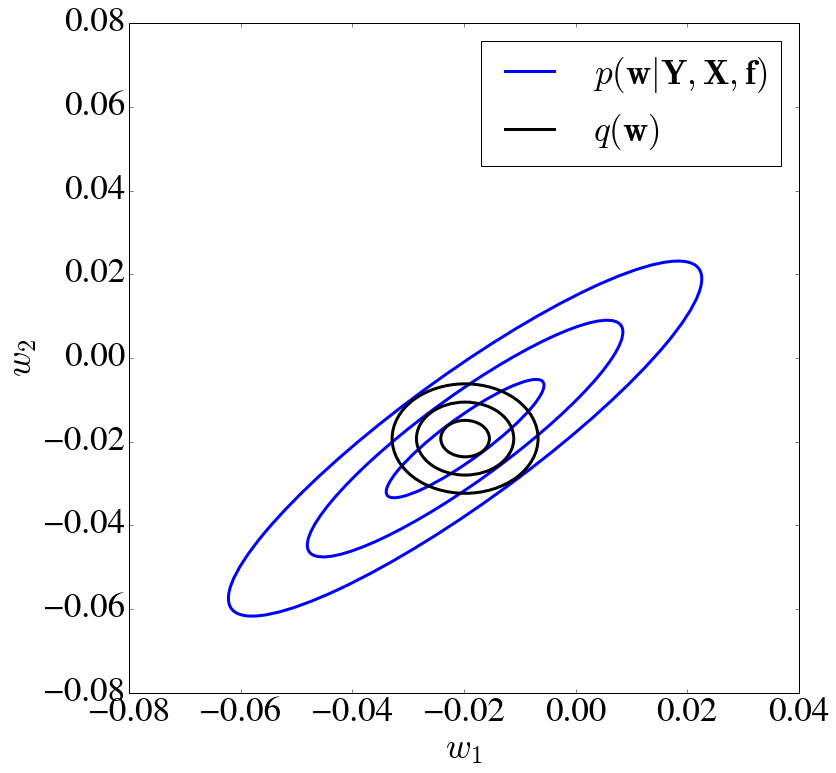

In [14]:
from matplotlib.patches import Ellipse
from plot_style import init_rc_params
init_rc_params()

plt.rcParams['figure.figsize'] = (12,12)
lambda_, v = np.linalg.eig(post_cov)
lambda_ = np.sqrt(lambda_)
ax = plt.subplot(111)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='b', fc='None', label=u'Апостериорное распределение параметров', linewidth=3)
    
    ax.add_artist(ell)
plt.legend([ell],[u'Апостериорное распределение параметров'])
old_ell = ell
side =  0.5/(post_cov[1,1]/np.linalg.det(post_cov))
cov_mean_field = np.array([[side, 0],[0,side]])
lambda_, v = np.linalg.eig(cov_mean_field)
lambda_ = np.sqrt(lambda_)
for j in range(1,4):
    ell = Ellipse(xy=post_mean,width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor='k', fc='None', label=u'Mean-field аппроксимация', linewidth=3)
    
    ax.add_artist(ell)
#plt.legend([old_ell, ell],[u'Апостериорное распределение параметров', u'Mean-field аппроксимация'])
plt.plot([-100],[-100], label=u'$p(\mathbf{w}|\mathbf{Y}, \mathbf{X},\mathbf{f})$', c='b', linewidth=3)
plt.plot([-100],[-100], label=u'$q(\mathbf{w})$', c='k', linewidth=3)
plt.legend(loc='best', fontsize=35)  
plt.tick_params(axis='both', which='major', labelsize=35)
plt.xlabel('$w_1$', fontsize=35)
plt.ylabel('$w_2$',fontsize=35)

def func(x, pos):  # formatter function takes tick label and tick position
    s = str(x)
    ind = s.index('.')
    return s[:ind] + ',' + s[ind+1:]   # change dot to comma




plt.xlim((-.08,.04))
plt.ylim((-.08,.08))

plt.savefig('/home/legin/phd/tex/presentations/mf.pdf', dpi=100)
